In [1]:
#NUCELOTIDE MUTATION ANALYSIS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Calculate the mutations from a reference sequence.

Parameters:
- df (DataFrame): DataFrame containing sequences.
- ge (list): List of nucleotides.
- ref_seq_index (int): Index of the reference sequence in the DataFrame.
    
Returns:
- result (ndarray): Matrix of mutation counts.
- ref_seq_size (int): Size of the reference sequence.

In [2]:
def calculate_mutations(df, ge, ref_seq_index=0):
    ref_seq = df.loc[ref_seq_index, 'Sequence']
    ref_seq_size = len(ref_seq)
    other_seqs = df.loc[ref_seq_index + 1:, 'Sequence']
    
    result = np.zeros((4, 4))
    
    for data_row in other_seqs:
        other_seq_size = len(data_row)
        it_len = min(ref_seq_size, other_seq_size)
        for j in range(it_len):
            if ref_seq[j] != data_row[j]:
                try:
                    id1 = ge.index(ref_seq[j])
                    id2 = ge.index(data_row[j])
                    result[id1, id2] += 1
                except ValueError:
                    pass
    
    return result, ref_seq_size

Mutation normalization: $$ \text{Mutacijų dažnis} = \left(\frac{\text{mutacija}}{\text{duomenų rinkinio ilgis} \times \text{referentinės sekos ilgis}} \right) \times 100 $$

In [3]:
def normalize_mutations(result, ref_seq_size, dataset_size):
    return (result / (ref_seq_size * dataset_size)) * 100

Plot the mutation rates as a stacked bar chart.

Parameters:
- rrf (ndarray): Normalized mutation matrix in percentages.
- nucleotides (list): List of nucleotide labels.
- colors (list): List of colors for the bars.
- output_file (str, optional): Path to save the plot image.

In [4]:
def plot_mutation_rates(rrf, nucleotides, colors, output_file=None):
    plt.figure(figsize=(10, 6))
    bottom = np.zeros(4)
    for i in range(4):
        plt.bar(nucleotides, rrf[:, i], bottom=bottom, color=colors[i], edgecolor='black', label=f'Mutation to {nucleotides[i]}')
        bottom += rrf[:, i]
    
    plt.xticks(range(4), nucleotides)
    plt.ylabel('Mutation Rate in %')
    plt.xlabel('Nucleotide')
    plt.title('Nucleotide Mutation Rates')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.box(False)
    
    for i in range(4):
        cumulative_height = 0
        for j in range(4):
            if rrf[j, i] > 0:
                label_position = cumulative_height + rrf[j, i] / 2
                plt.text(
                    i, label_position, f'{rrf[j, i]:.1f}%', 
                    ha='center', va='center', fontsize=10, color='black', weight='bold',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
                )
            cumulative_height += rrf[j, i]
    
    if output_file:
        plt.savefig(output_file)
    plt.show()

Calculate mutation rates over time.
    
Parameters:
- sorted_data (DataFrame): DataFrame containing sorted sequences.
- ge (list): List of nucleotides.
- ref_seq_index (int): Index of the reference sequence in the DataFrame.
    
Returns:
- ndarray: Timeseries data of mutation rates.

In [5]:
def calculate_mutation_timeseries(sorted_data, ge, ref_seq_index=0):
    ref_seq = sorted_data.loc[ref_seq_index, 'Sequence']
    ref_seq_size = len(ref_seq)
    other_seq = sorted_data.loc[ref_seq_index + 1:, 'Sequence']
    
    mutation_timeseries = np.zeros((len(sorted_data) - 1, 12))
    result3 = np.zeros((4, 4))
    ii = 1
    
    for i, data_row in enumerate(other_seq):
        other_seq_size = len(data_row)
        it_len = min(ref_seq_size, other_seq_size)
        
        for j in range(it_len):
            ref_base = ref_seq[j]
            other_base = data_row[j]
            
            id1 = get_base_index(ref_base, ge)
            id2 = get_base_index(other_base, ge)
            
            if id1 is not None and id2 is not None and id1 < 4 and id2 < 4:
                if ref_base != other_base:
                    result3[id1, id2] += 1
        
        rrf = (result3 / (ref_seq_size * ii)) * 100
        ii += 1
        
        forward3 = [rrf[0, 1], rrf[0, 2], rrf[0, 3], rrf[1, 2], rrf[1, 3], rrf[2, 3]]
        backward3 = [rrf[1, 0], rrf[2, 0], rrf[3, 0], rrf[2, 1], rrf[3, 1], rrf[3, 2]]
        
        fb = np.concatenate((forward3, backward3))
        mutation_timeseries[i, :] = fb
    
    return mutation_timeseries

# Get the index of a nucleotide base.
def get_base_index(base, ge):
    try:
        return ge.index(base)
    except ValueError:
        return None

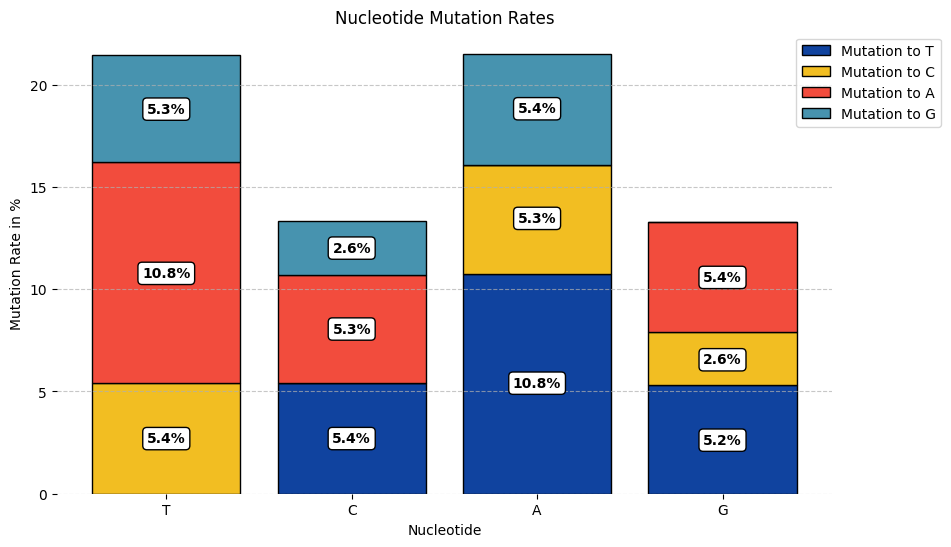

In [6]:
# Load dataset
df = pd.read_csv('../outputs/ascending_dates2.csv')
ge = ['T', 'C', 'A', 'G']

# Calculate mutations and normalize
result3, ref_seq_size = calculate_mutations(df, ge)
dataset_size = len(df)
rrf = normalize_mutations(result3, ref_seq_size, dataset_size)

# Plot mutation rates
colors = ['#10439F', '#F2BE22', '#F24C3D', '#4793AF']
nucleotides = ['T', 'C', 'A', 'G']
plot_mutation_rates(rrf, nucleotides, colors)

# Calculate mutation timeseries
sorted_data = pd.read_csv('../outputs/ascending_dates2.csv')
mutation_timeseries = calculate_mutation_timeseries(sorted_data, ge)

# Save mutation timeseries to CSV
mutation_timeseries_df = pd.DataFrame(mutation_timeseries, columns=[
    'T->C', 'T->A', 'T->G', 'C->A', 'C->G', 'A->G',
    'C->T', 'A->T', 'G->T', 'A->C', 'G->C', 'G->A'
])
mutation_timeseries_df.to_csv('../outputs/mutation_timeseries3.csv', index=False)

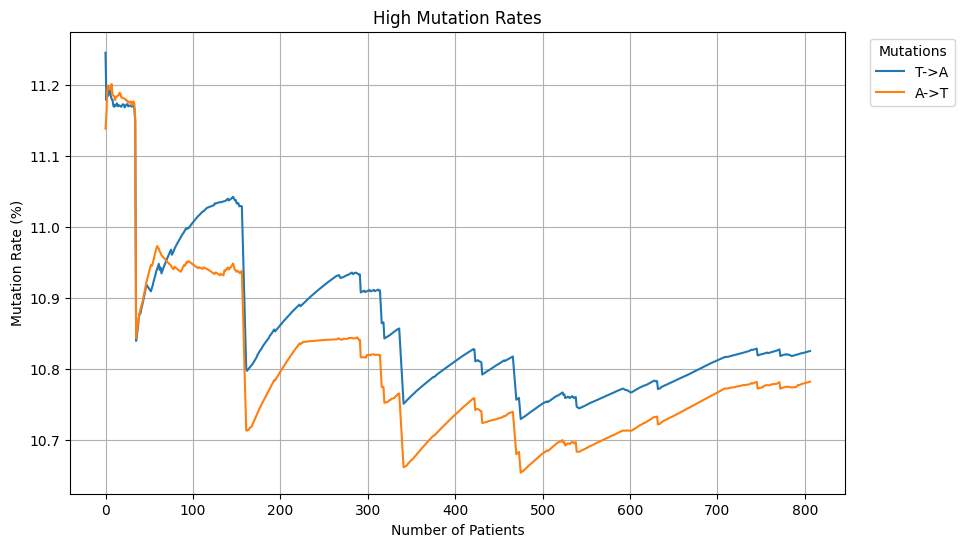

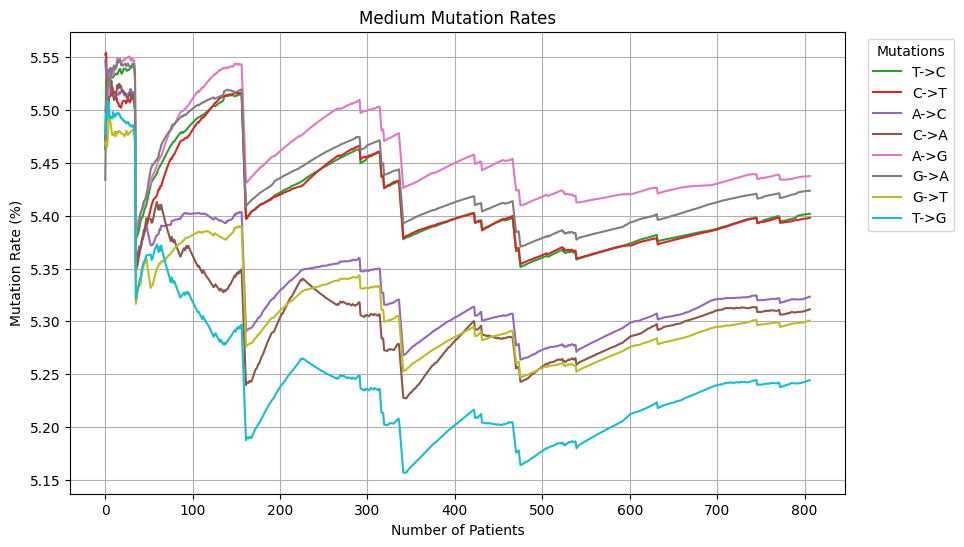

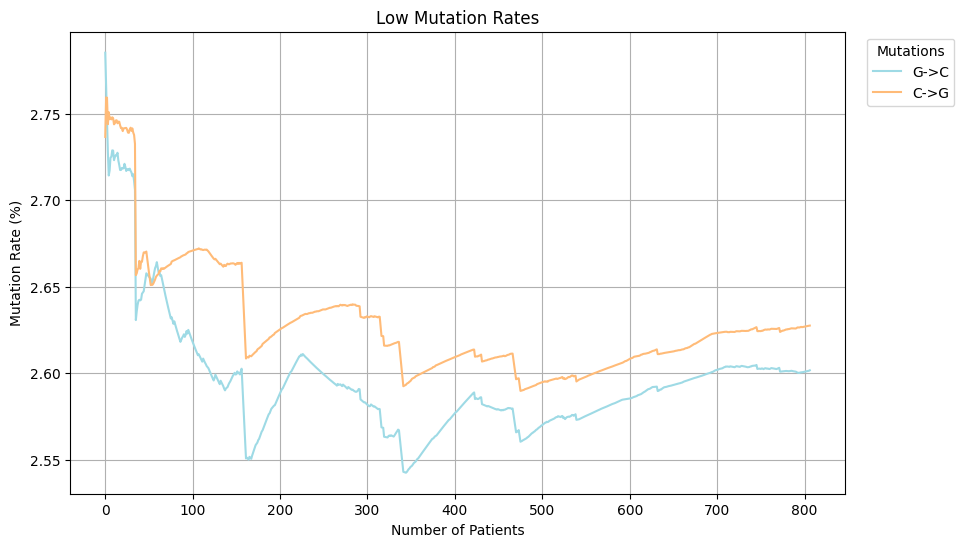

In [9]:
# unique_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
#                  '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#9edae5', '#ffbb78']

# # Plot each mutation type with a unique color
# plt.figure(figsize=(10, 6))
# for mutation, color in zip(mutation_timeseries_df.columns, unique_colors):
#     plt.plot(mutation_timeseries_df.index, mutation_timeseries_df[mutation], label=mutation, color=color)

# plt.xlabel('Number of Patients')
# plt.ylabel('Mutation Rate (%)')
# plt.legend(title='Mutations', loc='upper right', bbox_to_anchor=(1.15, 1))
# plt.grid(True)
# plt.show()

# Load dataset and calculate mutation timeseries
sorted_data = pd.read_csv('../outputs/ascending_dates2.csv')
mutation_timeseries = calculate_mutation_timeseries(sorted_data, ge)

# Save mutation timeseries to CSV
mutation_timeseries_df = pd.DataFrame(mutation_timeseries, columns=[
    'T->C', 'T->A', 'T->G', 'C->A', 'C->G', 'A->G',
    'C->T', 'A->T', 'G->T', 'A->C', 'G->C', 'G->A'
])
mutation_timeseries_df.to_csv('../outputs/mutation_timeseries3.csv', index=False)

# Define colors for each mutation type
unique_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
                 '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#9edae5', '#ffbb78']

high_mutation_rates = ['T->A', 'A->T']
medium_mutation_rates = ['T->C', 'C->T', 'A->C', 'C->A', 'A->G', 'G->A', 'G->T', 'T->G']
low_mutation_rates = ['G->C', 'C->G']

# Function to plot mutation rates
def plot_mutation_bulk(mutations, title, colors):
    plt.figure(figsize=(10, 6))
    for mutation in mutations:
        plt.plot(mutation_timeseries_df.index, mutation_timeseries_df[mutation], label=mutation, color=colors[mutation])
    plt.xlabel('Number of Patients')
    plt.ylabel('Mutation Rate (%)')
    plt.title(title)
    plt.legend(title='Mutations', loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.show()

# Plot high mutation rates
high_colors = {mutation: unique_colors[i] for i, mutation in enumerate(high_mutation_rates)}
plot_mutation_bulk(high_mutation_rates, 'High Mutation Rates', high_colors)

# Plot medium mutation rates
medium_colors = {mutation: unique_colors[i + len(high_mutation_rates)] for i, mutation in enumerate(medium_mutation_rates)}
plot_mutation_bulk(medium_mutation_rates, 'Medium Mutation Rates', medium_colors)

# Plot low mutation rates
low_colors = {mutation: unique_colors[i + len(high_mutation_rates) + len(medium_mutation_rates)] for i, mutation in enumerate(low_mutation_rates)}
plot_mutation_bulk(low_mutation_rates, 'Low Mutation Rates', low_colors)